In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 50)
sns.set(font_scale=1.5)

# Function Definitions

In [13]:
def data_wrangling(data, cols_to_clean=[], colstype_to_change=[], dtypes=[], dropna=0, drop_cols=[]): 
    
    ### Used to clean the datasets 
    
    if len(cols_to_clean):
        for i in cols_to_clean:
            if i.find('FARE')!=-1:
                data[i].replace('[a-zA-Z\$*]', '', regex=True,inplace=True) ### Replaces the pattern matched with the regular experssion.
            else:
                data[i].replace('[a-zA-Z\$*]', '0', regex=True,inplace=True)
            
    if len(colstype_to_change):
        zip_object = zip(colstype_to_change, dtypes)  ### This is used to select the respective index items from both the lists.

        for i, j in zip_object:
            if j=='datetime':
                data[i]=pd.to_datetime(data[i]) ### If dtype is datetime converts it to datetime
            else:
                data[i]=data[i].astype(j) ### Else converts it to given dtype.
                
    if len(drop_cols): ### To drop the required cols.
        data.drop(drop_cols, axis=1, inplace=True)
            
    if dropna==1: ### To drop rows containing any nulls
        data.dropna(inplace=True)
        
    return data


def sorted_routes(data):  
    
    ### Used to combine records of the origin and destination for round trips.
    
    data['Route']=data['ORIGIN']+'-'+data['DESTINATION'] ### Concats the data in 2 columns into a new column.
    data['Route']=data['Route'].apply(lambda i: i.split('-')) ### This command split the data in a column to list. Ex:- LAX-SFO->[LAX,SFO]
    data['Route']=data['Route'].apply(lambda i: sorted(i)) ### This command sorts all the data present in the list of a column
    data['Route']=data['Route'].apply(lambda i: i[0]+'-'+i[1]) ### This data concats list data using "-"(hyphen).
    data.drop(['ORIGIN', 'DESTINATION'], axis=1, inplace=True) ### Drops the columns in the list.
    return data['Route']


def revenue(baggage_tickets_revenue_data, avg_ticket_price_data, seating_capacity=200, bag_price=35): 
    
    ### To calculate the revenue from various dataframes, here the seating capacity and the bag price are default values 
    ### which can be changed as per the requirements.
    
    
    #### Lets calculate the Baggage Revenue.
    baggage_tickets_revenue_data['Number_Of_Passengers']=baggage_tickets_revenue_data['OCCUPANCY_RATE']*200 
    baggage_tickets_revenue_data['Baggage_Revenue']=(baggage_tickets_revenue_data['Number_Of_Passengers']*0.5)*35
    baggage=(baggage_tickets_revenue_data.groupby(['ORIGIN', "DESTINATION"]).sum()['Baggage_Revenue']).reset_index()
    baggage['Route']=sorted_routes(baggage)
    baggage=baggage.groupby('Route').sum()['Baggage_Revenue'].sort_values(ascending=False).reset_index() 
    
    #### Lets calculate the Avg. Ticket Price.
    avg_ticket_price=(avg_ticket_price_data.groupby(['ORIGIN', 'DESTINATION']).mean()['ITIN_FARE']).reset_index() 
    avg_ticket_price.rename(columns={"ITIN_FARE": 'Avg_Round_Trip_Fare'}, inplace=True)
    avg_ticket_price['Route']=sorted_routes(avg_ticket_price)
    avg_ticket_price=avg_ticket_price.groupby('Route').sum()['Avg_Round_Trip_Fare'].reset_index()
    
    #### Lets calculate the Tickets Revenue
    passengers=baggage_tickets_revenue_data.groupby(['ORIGIN', 'DESTINATION']).sum()['Number_Of_Passengers'].reset_index()  
    passengers['Route']=sorted_routes(passengers)
    passengers=passengers.groupby('Route').sum()['Number_Of_Passengers'].reset_index()
    tickets_revenue=data_munging(passengers, avg_ticket_price, on_key='Route')
    tickets_revenue['Tkt_Revenue']=tickets_revenue['Number_Of_Passengers']*tickets_revenue['Avg_Round_Trip_Fare']
    
    return baggage, avg_ticket_price, tickets_revenue, passengers


def costs(data, Fuel_Oil_Main_Crew_Costs=8, Depri_Insu_Oth_Costs=1.18, large_airport_cost=10000, medium_airport_cost=5000):
    
    ### To calculate the cost from data, here the Fuel, Oil, etc. costs are default values 
    ### which can be changed as per the requirements.
    
    #### Lets calculate the Delay Costs.
    data['Depart_Delay_Cost']=data['DEP_DELAY'].apply(lambda i: (i-15)*75 if (i-15)>0 else 0) 
    data['Arr_Delay_Cost']=data['ARR_DELAY'].apply(lambda i: (i-15)*75 if (i-15)>0 else 0)
    data['Total_Delay_Cost']=data['Arr_Delay_Cost']+data['Depart_Delay_Cost']
    
    #### Lets calculate Fuel, etc Costs
    data['Fuel_Oil_Main_Crew_Costs']=data['DISTANCE']*8 ## Fuel, etc Costs
    
    #### Lets calculate Insurance, etc Costs
    data['Depri_Insu_Oth_Costs']=data['DISTANCE']*(1.18) ## Insurance, etc Costs
    
    #### Lets calculate Airport Operational Costs
    data['Air_Oper_Costs']=data['ORIGIN_TYPE'].apply(lambda i: int(large_airport_cost) if i=='large_airport' else int(medium_airport_cost))  
    data['Air_Oper_Costs']=data['Air_Oper_Costs']+(data['DESTINATION_TYPE'].apply(lambda i: int(large_airport_cost) if i=='large_airport' else int(medium_airport_cost)))
    
    #### Lets calculate the total cost incurred by all the above.
    data['Total_Costs']=data['Air_Oper_Costs']+data['Total_Delay_Cost']+data['Depri_Insu_Oth_Costs']+data['Fuel_Oil_Main_Crew_Costs']
    
    costs=data.groupby(['ORIGIN', 'DESTINATION']).sum()[['Total_Delay_Cost', 'Fuel_Oil_Main_Crew_Costs', 'Depri_Insu_Oth_Costs', 'Air_Oper_Costs', 'Total_Costs']].reset_index()
    ### This is used to add all the individual costs for all the flights by grouping data with "ORIGIN" and "DESTINATION".
    
    costs['Route']=sorted_routes(costs)
    ### The fucntion is used to calculate the round trips.
    
    costs=costs.groupby('Route').sum().reset_index()
    ### Added all the costs for Round Trips.
    
    return data, costs

def competitors(flights_data):
    
    ### This is a function to calculate the number of unique operating carriers in each route.
    
    competetion=flights_data.groupby(['ORIGIN', 'DESTINATION']).nunique()['OP_CARRIER'].reset_index()

    competetion['Route']=sorted_routes(competetion)
    
    competetion=competetion.groupby('Route').mean().reset_index()
    ### Grouped by 'Route'  and calculated their mean. Since the the number of carriers from LAX-SFO is same as from SFO-LAX.

    competetion['OP_CARRIER']=competetion['OP_CARRIER'].astype('int')
    ### Converted the datatype of "OP_CARRIER" to "int".

    competetion.rename(columns={'OP_CARRIER': 'Number_Of_Competitors'}, inplace=True)
    ### Renamed the column.
    
    return competetion


def profit(revenue_data, costs_data, competitors_data, flights_data):
    
    ### The function created above is used to calculate profits for each round trip route and here we merge 
    ### multiple dataframes to show the key metrics.
    
    profits=data_munging(left_df=revenue_data, right_df=costs_data, on_key='Route')
    ## Joined the dataframe of revenue_data and costs_data by "Route" using "inner" join.

    profits=data_munging(left_df=profits, right_df=competitors_data, on_key='Route')
    ### Joined the dataframe of competitors_data(Number Of Competitors) and profits by "Route" using "inner" join.

    profits=data_munging(left_df=flights_data, right_df=profits, on_key="Route")
    ### Joined the dataframe of profits and flights_data(number of round trip flights per "Route") by "Route" 
    ### using "inner" join.

    profits['Profit']=profits['Total_Revenue']-profits['Total_Costs']
    ### Since, profits=Revenue-Costs.

    profits.insert(1, 'Number_Of_Competitors', profits.pop("Number_Of_Competitors"))
    ### Changes the position of the column "Number_Of_Competitors" to index 1 (position 2)

    profits.rename(columns={'Count':'Number_Of_RoundTrp_Flights'}, inplace=True)
    ### Renamed the column names from "Count" to "Number_Of_RoundTrp_Flights".

    profits['Profit_Per_Trip']=profits['Profit']/profits['Number_Of_RoundTrp_Flights']
    profits.insert(15, 'Profit_Per_Trip', profits.pop("Profit_Per_Trip"))
    
    return profits

def bep(profit_data):
    
    ### This function is used to calculate the break even analysis on the data, this takes in the profit_data.
    
    break_even_analysis=profit_data.sort_values(ascending=False, by='Profit').head(10)
    ### Considered only the top 10 results from the round_trip_stats dataframe.

    break_even_analysis['Sale_Per_Trip']=break_even_analysis['Total_Revenue']/break_even_analysis['Number_Of_RoundTrp_Flights']
    ### Since Sale per unit is Total Revenue/Number of flights.

    break_even_analysis['Cost_Per_Trip']=break_even_analysis['Total_Costs']/break_even_analysis['Number_Of_RoundTrp_Flights']
    ### Since Cost per unit is Total Cost/Number of flights.

    break_even_analysis['BEP(Required_RoundTrps)']=((90000000)/(break_even_analysis['Sale_Per_Trip']-break_even_analysis['Cost_Per_Trip'])).apply(np.ceil).astype('int')
    ### As per the forumla here the BEP=[Fixed Cost=Upfront Cost(90,000,000)]/[Sale Per Unit - Cost Per Unit]
    ### or BEP=[Fixed Cost=Upfront Cost(90,000,000)]/[Profit Per Unit]
    
    return break_even_analysis

def data_munging(left_df, right_df, join='inner', on_key='no_key', left_key=[], right_key=[]):
    
    ### This function is used to join (or) merge 2 datasets and does the operation by checking mutltiple conditions
    ### And gives an error message for the user to understand. 
    
    if len(left_key)==0 & len(right_key)==0:
        if on_key=='no_key':
            return (print('Pass in the "left_key" and "right_key" (or) pass in the on_key if column names are same for both the tables you want to join \non.\n'))
    
    if len(left_key)==0 & len(right_key)==0:
        return (pd.merge(left= left_df ,right=right_df, how=join, on=on_key))
    else:
        return (pd.merge(left=left_df, right=right_df, how=join, left_on=left_key, right_on=right_key))
    

# Data Quality

## 1) Flights Data

In [14]:
flights=pd.read_csv('Flights.csv', low_memory=False)
flights.head() ### This is used to see the first 5 rows of the data.

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.00,-6.00,0.00,143.0,1025.0,0.97
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.00,5.00,0.00,135.0,930.0,0.55
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.00,4.00,0.00,132.0,930.0,0.91
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.00,14.00,0.00,136.0,930.0,0.67
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.00,-17.00,0.00,151.0,1005.0,0.62


In [15]:
flights.info() ### Here we can see that the "AIR_TIME" and "DISTANCE" columns are of type object 
               ### so we have convert them to float and the datatype of "FL_DATE" is object which
               ### changed to datatime type.
               ### The datatypes of AIRPORT_ID's are "int" as the ID's are not to be manipulated 
               ### and there no mathmatical operations being performed, we are going to convert it to "object" datatype.              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915886 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   TAIL_NUM           object 
 3   OP_CARRIER_FL_NUM  object 
 4   ORIGIN_AIRPORT_ID  int64  
 5   ORIGIN             object 
 6   ORIGIN_CITY_NAME   object 
 7   DEST_AIRPORT_ID    int64  
 8   DESTINATION        object 
 9   DEST_CITY_NAME     object 
 10  DEP_DELAY          float64
 11  ARR_DELAY          float64
 12  CANCELLED          float64
 13  AIR_TIME           object 
 14  DISTANCE           object 
 15  OCCUPANCY_RATE     float64
dtypes: float64(4), int64(2), object(10)
memory usage: 233.9+ MB


In [16]:
flights.isna().sum()

FL_DATE                  0
OP_CARRIER               0
TAIL_NUM             12156
OP_CARRIER_FL_NUM        0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
ORIGIN_CITY_NAME         0
DEST_AIRPORT_ID          0
DESTINATION              0
DEST_CITY_NAME           0
DEP_DELAY            50351
ARR_DELAY            55991
CANCELLED                0
AIR_TIME             56551
DISTANCE               630
OCCUPANCY_RATE         310
dtype: int64

In [17]:
filghts=flights[flights['CANCELLED']==0.0]  ### Removed the cancelled flights from the dataframe.
flights=data_wrangling(data=flights, cols_to_clean=['AIR_TIME', "DISTANCE"], colstype_to_change=['AIR_TIME', 'DISTANCE', 'FL_DATE', 'DEST_AIRPORT_ID', 'ORIGIN_AIRPORT_ID'], dtypes=['float', 'float', 'datetime', 'str', 'str'], dropna=1)
flights.info()
### data_wrangling() is a function call to clean the dataframe. From the below information we can see that the 
### datatypes of the columns "AIR_TIME", "DISTANCE", "FL_DATE" have been changed as per the requirement.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1858595 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   FL_DATE            datetime64[ns]
 1   OP_CARRIER         object        
 2   TAIL_NUM           object        
 3   OP_CARRIER_FL_NUM  object        
 4   ORIGIN_AIRPORT_ID  object        
 5   ORIGIN             object        
 6   ORIGIN_CITY_NAME   object        
 7   DEST_AIRPORT_ID    object        
 8   DESTINATION        object        
 9   DEST_CITY_NAME     object        
 10  DEP_DELAY          float64       
 11  ARR_DELAY          float64       
 12  CANCELLED          float64       
 13  AIR_TIME           float64       
 14  DISTANCE           float64       
 15  OCCUPANCY_RATE     float64       
dtypes: datetime64[ns](1), float64(6), object(9)
memory usage: 241.1+ MB


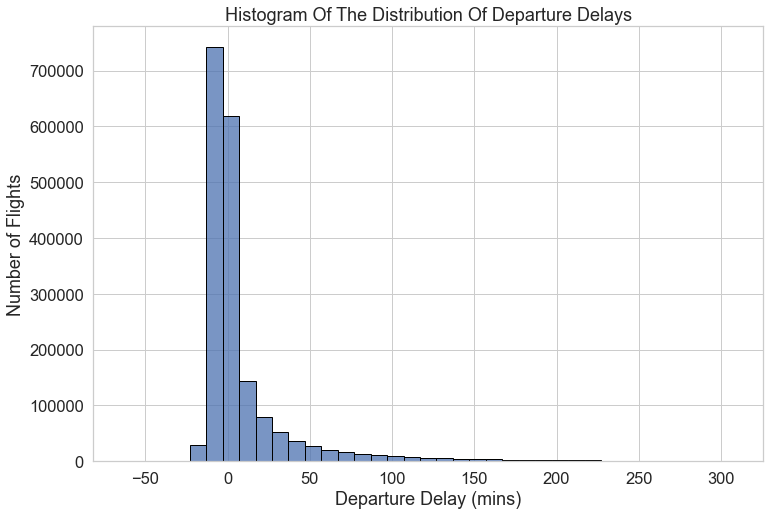

In [18]:
### Lets visualize the distribution of the departure delays
sns.set_style(style='whitegrid')
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
sns.histplot(data=flights[flights['DEP_DELAY'] < 300], x='DEP_DELAY', ax=ax, binwidth=10, edgecolor="black")
plt.xlabel('Departure Delay (mins)')
plt.ylabel('Number of Flights')
plt.title('Histogram Of The Distribution Of Departure Delays')
plt.show()

#### From the plot above we see that there more number of flights which have taken off before the departure time which are around 140K whereas the number flights which have departed after the 15 minutes grace time are low in number, however steps are needed to be taken to ensure that those flights are not delayed which helps the clients in saving the costs.

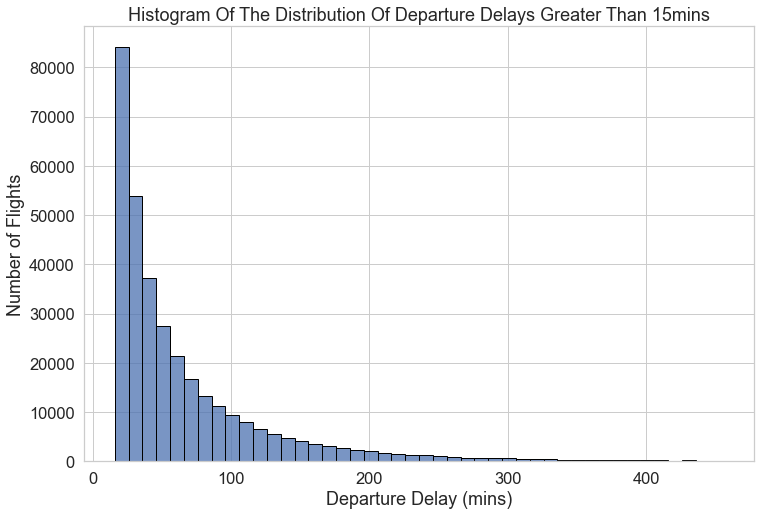

In [19]:
### Lets see how many flights were delayed by 15 mins or more
sns.set_style(style='whitegrid')
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
sns.histplot(data=flights[(flights['DEP_DELAY']>=16) & (flights['DEP_DELAY']<450)], x='DEP_DELAY', ax=ax, binwidth=10, edgecolor="black")
plt.xlabel('Departure Delay (mins)')
plt.ylabel('Number of Flights')
plt.title('Histogram Of The Distribution Of Departure Delays Greater Than 15mins')
plt.show()

#### There are quite a good number of flights that are delayed between 16 and 100 minutes, there are around 10K flights that leave after 17minutes and around 1K flights that leave after 100 minutes.  And there are less number of flights that take off after 150 minutes.  From this we can see that reduction in the delay times can reduce the costs.

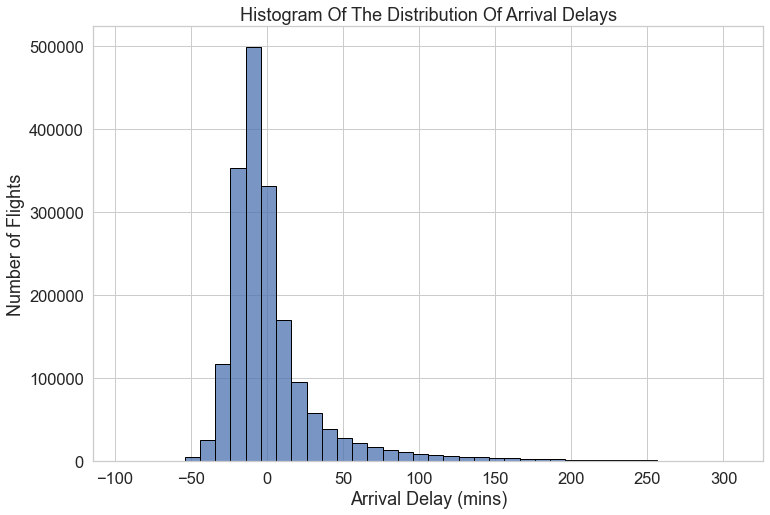

In [20]:
### Lets visualize the distribution of the arrival delays
sns.set_style(style='whitegrid')
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
sns.histplot(data=flights[flights['ARR_DELAY'] < 300], x='ARR_DELAY', ax=ax, binwidth=10, edgecolor="black")
plt.xlabel('Arrival Delay (mins)')
plt.ylabel('Number of Flights')
plt.title('Histogram Of The Distribution Of Arrival Delays')
plt.show()

#### A lot of flights have arrived much before the actual arrival time, but there are flights that have arrived after the 15 minutes grace time which are cause for the costs. 

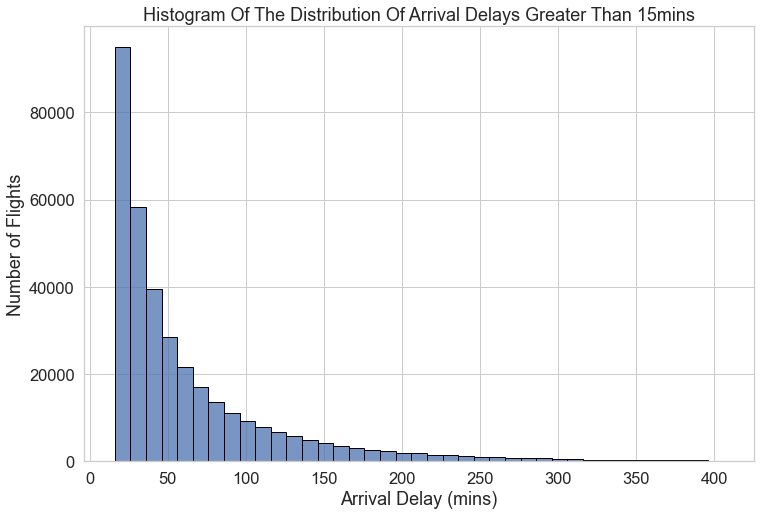

In [21]:
### Lets visualize the distribution of the arrival delays greater than 15mins
sns.set_style(style='whitegrid')
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
sns.histplot(data=flights[(flights['ARR_DELAY'] > 15) & (flights['ARR_DELAY'] < 400)], x='ARR_DELAY', ax=ax, binwidth=10, edgecolor="black")
plt.xlabel('Arrival Delay (mins)')
plt.ylabel('Number of Flights')
plt.title('Histogram Of The Distribution Of Arrival Delays Greater Than 15mins')
plt.show()

#### This plot looks exactly similar to the plot we have derived for departure delays greater than 15mins, Its evident from this that flights that have departed late will be arriving later, but here we can see there are approximately 1k flights that have arrived 1minute late than expected. 

In [22]:
### lets see the number of null values in each column
flights.isna().sum()

FL_DATE              0
OP_CARRIER           0
TAIL_NUM             0
OP_CARRIER_FL_NUM    0
ORIGIN_AIRPORT_ID    0
ORIGIN               0
ORIGIN_CITY_NAME     0
DEST_AIRPORT_ID      0
DESTINATION          0
DEST_CITY_NAME       0
DEP_DELAY            0
ARR_DELAY            0
CANCELLED            0
AIR_TIME             0
DISTANCE             0
OCCUPANCY_RATE       0
dtype: int64

In [23]:
flights.shape

(1858595, 16)

In [24]:
flights.describe()
### Looking at the information below,Since we have dataframe now has only non-cancelled flights the "AIR_TIME" and "DISTANCE" 
### cannot be negative values (min values) we have to change the values to positive which might have been entered incorrectly.

,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
count,1858595.00,1858595.00,1858595.00,1858595.00,1858595.00,1858595.00
mean,10.73,5.65,0.00,109.28,771.42,0.65
std,49.97,52.42,0.00,70.52,582.40,0.20
min,-63.00,-94.00,0.00,-121.00,-1947.00,0.30
25%,-6.00,-15.00,0.00,58.00,343.00,0.48
50%,-2.00,-6.00,0.00,91.00,612.00,0.65
75%,7.00,8.00,0.00,139.00,1013.00,0.83
max,2941.00,2923.00,0.00,2222.00,9898.00,1.00


In [25]:
flights['AIR_TIME']=flights['AIR_TIME'].apply(lambda i: i*(-1) if (i<0) else i)
flights['DISTANCE']=flights['DISTANCE'].apply(lambda i: i*(-1) if (i<0) else i)
flights.describe()
### From the information below we can see that the min values are set to zero as the we dont know what is the value 
### to be assigned when they are zero.

,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
count,1858595.00,1858595.00,1858595.00,1858595.00,1858595.00,1858595.00
mean,10.73,5.65,0.00,109.29,771.47,0.65
std,49.97,52.42,0.00,70.50,582.32,0.20
min,-63.00,-94.00,0.00,0.00,0.00,0.30
25%,-6.00,-15.00,0.00,58.00,343.00,0.48
50%,-2.00,-6.00,0.00,91.00,612.00,0.65
75%,7.00,8.00,0.00,139.00,1013.00,0.83
max,2941.00,2923.00,0.00,2222.00,9898.00,1.00


### Data Quality Issue for the Flights Data are:
### 1) The "AIR_TIME" and "DISTANCE" columns are of type object  so we have converted them to float and the datatype of "FL_DATE" is object which is changed to datatime type.
### 2) As the datatypes of "AIRPORT_ID's" are both 'int', I have converted it to datatype of 'object'.
### 3) Since we chose a dataframe of non-cancelled flights the "AIR_TIME" and "DISTANCE"  cannot be negative values  as thier min values so, we changed the values to positive which might have been entered incorrectly.
### 4) Using the describe function we have mean, dispersion of the data etc.  So we see that there are approximately 6% of the data which have missing values. So, we need to drop such records using dropna.

## 2) Airports

In [26]:
airports=pd.read_csv('Airport_Codes.csv')

airports.head()

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
0,heliport,Total Rf Heliport,11.00,NaN,US,Bensalem,NaN,"-74.93360137939453, 40.07080078125"
1,small_airport,Aero B Ranch Airport,3435.00,NaN,US,Leoti,NaN,"-101.473911, 38.704022"
2,small_airport,Lowell Field,450.00,NaN,US,Anchor Point,NaN,"-151.695999146, 59.94919968"
3,small_airport,Epps Airpark,820.00,NaN,US,Harvest,NaN,"-86.77030181884766, 34.86479949951172"
4,closed,Newport Hospital & Clinic Heliport,237.00,NaN,US,Newport,NaN,"-91.254898, 35.6087"


In [27]:
airports=airports[(airports['ISO_COUNTRY']=='US') & ((airports['TYPE']=='medium_airport') | (airports['TYPE']=='large_airport'))]

### We have kept only the data belonging to the US region and airport type with either a medium or a large airport.

In [28]:
airports.shape

(858, 8)

In [29]:
airports.info()
### From the information below we can see that the "CONTINENT" has all records with NULL values. So we can drop that column.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 6194 to 50008
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          858 non-null    object 
 1   NAME          858 non-null    object 
 2   ELEVATION_FT  855 non-null    float64
 3   CONTINENT     0 non-null      object 
 4   ISO_COUNTRY   858 non-null    object 
 5   MUNICIPALITY  855 non-null    object 
 6   IATA_CODE     821 non-null    object 
 7   COORDINATES   858 non-null    object 
dtypes: float64(1), object(7)
memory usage: 60.3+ KB


In [30]:
airports.isna().sum()

TYPE              0
NAME              0
ELEVATION_FT      3
CONTINENT       858
ISO_COUNTRY       0
MUNICIPALITY      3
IATA_CODE        37
COORDINATES       0
dtype: int64

In [31]:
airports=data_wrangling(airports, drop_cols=['CONTINENT'], dropna=1)
### The above function has dropped the columns given above and also drops null records as the dropna is 1

In [32]:
airports.isna().sum()

TYPE            0
NAME            0
ELEVATION_FT    0
ISO_COUNTRY     0
MUNICIPALITY    0
IATA_CODE       0
COORDINATES     0
dtype: int64

### Data Quality Issues for Airports Data are: 
### 1) We can see that after filtering the data to "US" region and to medium and large type airports, there are no values in the "CONTINENT"  which can be dropped
### 2) And also after filtering the data we can see that there are a few missing values in "IATA_CODE" where it acts as the identifier for data. So, we drop null records.

## 3) Tickets

In [33]:
tickets=pd.read_csv('Tickets.csv')

tickets.head()

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,201912723049,2019,1,ABI,US,TX,Texas,1.00,MQ,1.00,736.0,DAB
1,201912723085,2019,1,ABI,US,TX,Texas,1.00,MQ,1.00,570.0,COS
2,201912723491,2019,1,ABI,US,TX,Texas,1.00,MQ,1.00,564.0,MCO
3,201912723428,2019,1,ABI,US,TX,Texas,1.00,MQ,1.00,345.0,LGA
4,201912723509,2019,1,ABI,US,TX,Texas,0.00,MQ,1.00,309.0,MGM


In [34]:
tickets.shape

(1167285, 12)

In [35]:
tickets.info()
### From the below information we can see that the datatype of the "ITIN_FARE" is object but as we need it in float we need to 
### be changing its datatype.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167285 entries, 0 to 1167284
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ITIN_ID            1167285 non-null  int64  
 1   YEAR               1167285 non-null  int64  
 2   QUARTER            1167285 non-null  int64  
 3   ORIGIN             1167285 non-null  object 
 4   ORIGIN_COUNTRY     1167285 non-null  object 
 5   ORIGIN_STATE_ABR   1167285 non-null  object 
 6   ORIGIN_STATE_NM    1167285 non-null  object 
 7   ROUNDTRIP          1167285 non-null  float64
 8   REPORTING_CARRIER  1167285 non-null  object 
 9   PASSENGERS         1165308 non-null  float64
 10  ITIN_FARE          1166325 non-null  object 
 11  DESTINATION        1167285 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 106.9+ MB


In [36]:
tickets=tickets[(tickets['ORIGIN_COUNTRY']=='US') & (tickets['YEAR']==2019) & (tickets['QUARTER']==1) & (tickets['ROUNDTRIP']==1.0)]

### Here we have only kept the records consisting of US region, of Q1-2019 and considered only the roundtrip tickets.

In [37]:
tickets.isna().sum()

ITIN_ID                 0
YEAR                    0
QUARTER                 0
ORIGIN                  0
ORIGIN_COUNTRY          0
ORIGIN_STATE_ABR        0
ORIGIN_STATE_NM         0
ROUNDTRIP               0
REPORTING_CARRIER       0
PASSENGERS           1197
ITIN_FARE             560
DESTINATION             0
dtype: int64

In [38]:
tickets=data_wrangling(tickets, cols_to_clean=['ITIN_FARE'], colstype_to_change=['ITIN_FARE', "YEAR", 'QUARTER'], dtypes=['float', 'str', 'str'], dropna=1)
tickets.info()
### The function above clean the "ITIN_FARE" column as it has bad data and converts it to float and also drops the records
### having null values.
### Since the datatypes of "YEAR" and "QUARTER" are of datatype 'int', I have converted it to 'str' as we dont want any 
### mathematical operations to be performed on such data.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 706849 entries, 0 to 1167284
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ITIN_ID            706849 non-null  int64  
 1   YEAR               706849 non-null  object 
 2   QUARTER            706849 non-null  object 
 3   ORIGIN             706849 non-null  object 
 4   ORIGIN_COUNTRY     706849 non-null  object 
 5   ORIGIN_STATE_ABR   706849 non-null  object 
 6   ORIGIN_STATE_NM    706849 non-null  object 
 7   ROUNDTRIP          706849 non-null  float64
 8   REPORTING_CARRIER  706849 non-null  object 
 9   PASSENGERS         706849 non-null  float64
 10  ITIN_FARE          706849 non-null  float64
 11  DESTINATION        706849 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 70.1+ MB


In [39]:
tickets.describe()

,ITIN_ID,ROUNDTRIP,PASSENGERS,ITIN_FARE
count,706849.00,706849.00,706849.00,706849.00
mean,173316167738.64,1.00,1.94,473.38
std,66810828235.67,0.00,5.04,344.21
min,2019119.00,1.00,1.00,0.00
25%,201911580227.00,1.00,1.00,279.00
50%,201912831588.00,1.00,1.00,416.00
75%,201914009173.00,1.00,1.00,596.00
max,201915258097.00,1.00,681.00,38400.00


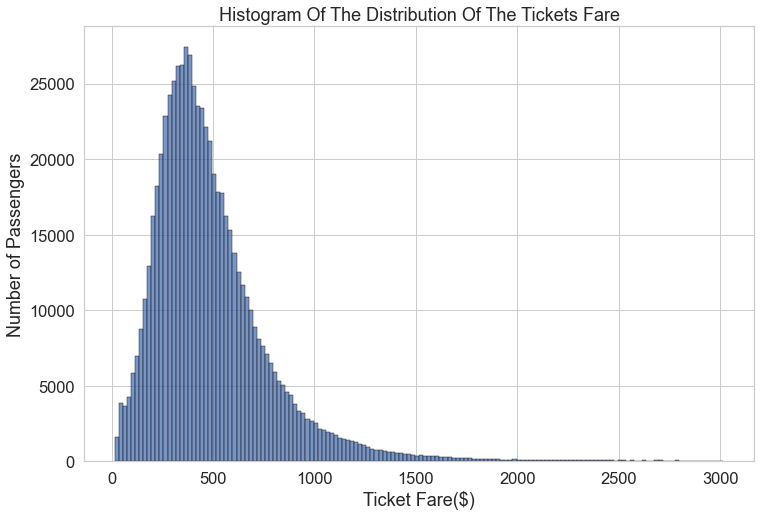

In [40]:
### This is a plotly command to visualize the Distribution of the ticket fares.
# fig=px.histogram(data_frame=tickets[(tickets['ITIN_FARE']>15) & (tickets['ITIN_FARE']<5000)], x='ITIN_FARE',
#                 labels={
#                     'ITIN_FARE' : 'Ticket Fare'
#                 }, title='Histogram of the Distribution Of The Tickets Fare')
# fig.update_layout(yaxis_title='Number of Passengers')

sns.set_style(style='whitegrid')
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
sns.histplot(data=tickets[(tickets['ITIN_FARE']>15) & (tickets['ITIN_FARE']<3000)], x='ITIN_FARE', ax=ax, binwidth=20, edgecolor="black")
plt.xlabel('Ticket Fare($)')
plt.ylabel('Number of Passengers')
plt.title('Histogram Of The Distribution Of The Tickets Fare')
plt.show()

#### The average ticket fare is around 470 dollars and there are around 7000 passengers where they have paid around 400 dollars and the data is right skewed data as there are a few people who paid a lot. This might due to the last minute booking or the seating class they chose on the flight. 

### Data Quality Issues for Tickets are: 
### 1) The datatype of the "ITIN_FARE" column is intially object so we need to change to float in order to perform the operations.
### 2) We can see that there a few missing values from the "ITIN_FARE" and "PASSENGERS" where they are used to perform operations so as these are null we need to drop these records.

## Now, as the data quality check for all 3 different data's lets go ahead and proceed with the required analysis

In [41]:
airports.head()

,TYPE,NAME,ELEVATION_FT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
6194,medium_airport,Aleknagik / New Airport,66.00,US,Aleknagik,WKK,"-158.617996216, 59.2826004028"
26143,medium_airport,Lehigh Valley International Airport,393.00,US,Allentown,ABE,"-75.44080352783203, 40.652099609375"
26144,medium_airport,Abilene Regional Airport,1791.00,US,Abilene,ABI,"-99.68190002440001, 32.4113006592"
26145,large_airport,Albuquerque International Sunport,5355.00,US,Albuquerque,ABQ,"-106.609001, 35.040199"
26146,medium_airport,Aberdeen Regional Airport,1302.00,US,Aberdeen,ABR,"-98.42179870605469, 45.449100494384766"


In [42]:
flights_airports_origin_destination=data_munging(left_df=flights, right_df=airports.iloc[:, [0,5]], left_key=['ORIGIN'], right_key=['IATA_CODE'])
### The above statement in used to join the flights dataframe and airports dataframe using the "inner" join method on their 
### respective origin airport codes and get only the first column(TYPE) from the airports data.

flights_airports_origin_destination.rename(columns={'TYPE':'ORIGIN_TYPE', 'IATA_CODE':'ORIGIN_IATA_CODE'}, inplace=True)
### The above statement is used to rename the column name from "TYPE" to "ORIGIN_TYPE"

flights_airports_origin_destination=data_munging(flights_airports_origin_destination, airports.iloc[:, [0,5]], left_key=['DESTINATION'], right_key=['IATA_CODE'])
### The above statement in used to join the flights dataframe and airports dataframe using the "inner" join method on their 
### respective destination airport codes and get only the first column(TYPE) from the airports data.

flights_airports_origin_destination.rename(columns={'TYPE':'DESTINATION_TYPE', 'IATA_CODE':'DESTINATION_IATA_CODE'}, inplace=True)
### The above statement is used to rename the column name from "TYPE" to "DESTINATION_TYPE"

flights_airports_origin_destination=flights_airports_origin_destination[((flights_airports_origin_destination['ORIGIN_TYPE']=='large_airport') | (flights_airports_origin_destination['ORIGIN_TYPE']=='medium_airport')) & ((flights_airports_origin_destination['DESTINATION_TYPE']=='large_airport') | (flights_airports_origin_destination['DESTINATION_TYPE']=='medium_airport'))]

In [43]:
flights_airports_origin_destination.describe()

,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
count,1826886.00,1826886.00,1826886.00,1826886.00,1826886.00,1826886.00
mean,10.70,5.60,0.00,108.85,767.40,0.65
std,49.75,52.20,0.00,70.42,581.25,0.20
min,-63.00,-94.00,0.00,0.00,0.00,0.30
25%,-6.00,-15.00,0.00,58.00,343.00,0.48
50%,-2.00,-6.00,0.00,90.00,606.00,0.65
75%,7.00,8.00,0.00,138.00,1005.00,0.83
max,2941.00,2923.00,0.00,2222.00,9898.00,1.00


In [44]:
### This method is used to see the number of rows and columns in the result.
flights_airports_origin_destination.shape

(1826886, 20)

### Question 1) The 10 busiest round trip routes in terms of number of round trip flights in the quarter.

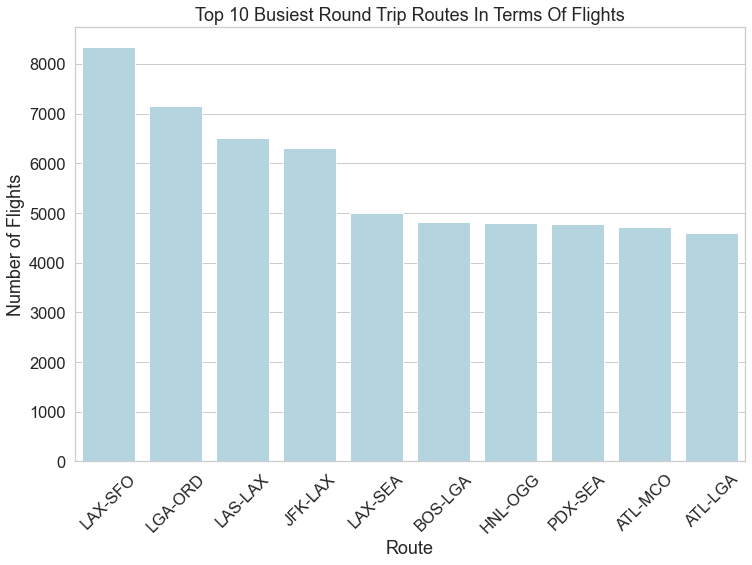

In [45]:
flights_airports_origin_destination.head()
busy_routes=flights_airports_origin_destination.groupby(['ORIGIN', 'DESTINATION']).count()['OP_CARRIER_FL_NUM'].reset_index()
### This is used to group by similar data of ORIGIN and DESTINATION columns and count the number of carriers in the routes.

busy_routes['Route']=sorted_routes(busy_routes)
### The function is used to gather the round trip routes.

busy_routes.rename(columns={'OP_CARRIER_FL_NUM':'Count'}, inplace=True)
### This is used to rename the column.

busy_routes=busy_routes.groupby('Route').sum().reset_index()
### Here we have grouped the data by "Route" and chose the sum of the flights for the round trip.
### As given in the data that we can assume each flight is dedicated for round trip.

sns.set_style(style='whitegrid')
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
sns.barplot(data=busy_routes.sort_values(ascending=False, by='Count').head(10), x='Route', y='Count', ax=ax, color='lightblue')
plt.xlabel('Route')
plt.ylabel('Number of Flights')
plt.title('Top 10 Busiest Round Trip Routes In Terms Of Flights')
plt.xticks(rotation=45)
plt.show()

# Revenue Calculation

In [46]:
baggage_revenue, avg_ticket_price, tickets_revenue, passengers = revenue(baggage_tickets_revenue_data=flights_airports_origin_destination, avg_ticket_price_data=tickets)
### revenue() is a function call to calculate the individual revenues and have passed the returned to the baggae_revenue,
### avg_ticket_price, tickets_revenue.

### 1) Baggage Revenue

In [47]:
baggage_revenue.head(10)
### Used to show the top 10 routes with baggage revenue in descending order.

,Route,Baggage_Revenue
0,LAX-SFO,18928770.00
1,LGA-ORD,16234575.00
2,LAS-LAX,14785400.00
3,JFK-LAX,14331100.00
4,LAX-SEA,11436530.00
5,BOS-LGA,10970295.00
6,HNL-OGG,10865260.00
7,PDX-SEA,10854200.00
8,ATL-MCO,10699920.00
9,ATL-LGA,10460135.00


### 2) Passengers Count

In [48]:
passengers.head(10)

,Route,Number_Of_Passengers
0,ABE-ATL,56796.00
1,ABE-CLT,66374.00
2,ABE-DTW,63976.00
3,ABE-FLL,4842.00
4,ABE-ORD,41304.00
5,ABE-PHL,46428.00
6,ABE-PIE,11440.00
7,ABE-SFB,33020.00
8,ABI-DFW,127680.00
9,ABQ-ATL,43214.00


### 3) Tickets Revenue

In [49]:
tickets_revenue.sort_values(ascending=False, by='Tkt_Revenue')
### Used to show the top 10 routes with tickets revenue in descending order.

,Route,Number_Of_Passengers,Avg_Round_Trip_Fare,Tkt_Revenue
1987,JFK-LAX,818920.00,1913.14,1566705600.03
2013,JFK-SFO,480996.00,1633.03,785482367.85
2783,SLC-TWF,77504.00,10115.42,783985253.33
1562,EWR-SFO,313516.00,2147.45,673259467.48
2178,LGA-ORD,927690.00,722.37,670139040.89
...,...,...,...,...
1682,GJT-LAX,142.00,822.78,116834.44
2555,ORD-TWF,84.00,1201.09,100891.64
1212,DEN-PAE,294.00,194.00,57036.00
2678,PSP-SJC,84.00,468.43,39348.00


### 4) Total Revenue

In [50]:
revenues=data_munging(tickets_revenue, baggage_revenue, on_key='Route')
### I have joined tickets_revenue data with baggage_revenue using "inner" join on the "Route" column. To get the information
### about all the revenues in one place.

revenues['Total_Revenue']=revenues['Baggage_Revenue']+revenues['Tkt_Revenue']
### As Total Revenue is a addtion of all the revenues. 

revenues.sort_values(ascending=False, by='Total_Revenue').head(10)
### Top 10 Routes ordered by the Total_Revenue in descending order.

,Route,Number_Of_Passengers,Avg_Round_Trip_Fare,Tkt_Revenue,Baggage_Revenue,Total_Revenue
1987,JFK-LAX,818920.00,1913.14,1566705600.03,14331100.00,1581036700.03
2013,JFK-SFO,480996.00,1633.03,785482367.85,8417430.00,793899797.85
2783,SLC-TWF,77504.00,10115.42,783985253.33,1356320.00,785341573.33
2178,LGA-ORD,927690.00,722.37,670139040.89,16234575.00,686373615.89
1562,EWR-SFO,313516.00,2147.45,673259467.48,5486530.00,678745997.48
2137,LAX-SFO,1081644.00,588.83,636907803.04,18928770.00,655836573.04
184,ATL-LGA,597722.00,917.50,548409815.17,10460135.00,558869950.17
181,ATL-LAX,399890.47,1306.75,522557118.43,6998083.14,529555201.57
1113,DCA-ORD,477842.00,1041.35,497598596.01,8362235.00,505960831.01
2119,LAX-ORD,482354.33,973.92,469775114.38,8441200.72,478216315.10


# Average Delays Calculation

In [51]:
avg_delays=flights_airports_origin_destination.groupby(['ORIGIN', 'DESTINATION']).mean()[['DEP_DELAY', 'ARR_DELAY']].reset_index()
### This is used to calculate the average delays for Departure and Arrival by group on similar records with "ORIGIN" 
### and "DESTINATION".

avg_delays['Route']=sorted_routes(avg_delays)
### sorted_routes() function is used to calculate the round trip routes.

avg_delays.rename(columns={'DEP_DELAY': 'Avg_Departure_Delay', 'ARR_DELAY': 'Avg_Arrival_Delay'}, inplace=True)
### Renamed the columns "DEP_DELAY" and "ARR_DELAY".

avg_delays=avg_delays.groupby('Route').mean().reset_index()
avg_delays.head()

,Route,Avg_Departure_Delay,Avg_Arrival_Delay
0,ABE-ATL,6.87,2.56
1,ABE-CLT,3.84,1.47
2,ABE-DTW,13.70,5.98
3,ABE-FLL,5.40,4.25
4,ABE-ORD,28.99,23.67


# Costs

In [52]:
flights_airports_origin_destination, cost=costs(flights_airports_origin_destination)
### costs() function is used to calculate all the costs given per flight.

flights_airports_origin_destination.head()

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,ORIGIN_TYPE,ORIGIN_IATA_CODE,DESTINATION_TYPE,DESTINATION_IATA_CODE,Number_Of_Passengers,Baggage_Revenue,Depart_Delay_Cost,Arr_Delay_Cost,Total_Delay_Cost,Fuel_Oil_Main_Crew_Costs,Depri_Insu_Oth_Costs,Air_Oper_Costs,Total_Costs
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.00,-6.00,0.00,143.00,1025.00,0.97,large_airport,RSW,large_airport,CLE,194.00,3395.00,0.00,0.00,0.00,8200.00,1209.50,20000,29409.50
1,2019-03-09,WN,N754SW,3016,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-7.00,-22.00,0.00,137.00,1025.00,0.63,large_airport,RSW,large_airport,CLE,126.00,2205.00,0.00,0.00,0.00,8200.00,1209.50,20000,29409.50
2,2019-03-24,UA,N14249,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-16.00,-9.00,0.00,129.00,1025.00,0.98,large_airport,RSW,large_airport,CLE,196.00,3430.00,0.00,0.00,0.00,8200.00,1209.50,20000,29409.50
3,2019-03-11,UA,N14240,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-1.00,8.00,0.00,138.00,1025.00,0.36,large_airport,RSW,large_airport,CLE,72.00,1260.00,0.00,0.00,0.00,8200.00,1209.50,20000,29409.50
4,2019-03-10,UA,N11206,2350,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-6.00,1.00,0.00,141.00,1025.00,0.45,large_airport,RSW,large_airport,CLE,90.00,1575.00,0.00,0.00,0.00,8200.00,1209.50,20000,29409.50


In [53]:
cost=data_munging(avg_delays, cost, on_key="Route")
### We have merged the data with the average delays in each round trip route in case the client wants to see and analyze.

cost.sort_values(ascending=False, by='Total_Costs')
### This shows the costs table sorted by Total_Costs in descending order.

,Route,Avg_Departure_Delay,Avg_Arrival_Delay,Total_Delay_Cost,Fuel_Oil_Main_Crew_Costs,Depri_Insu_Oth_Costs,Air_Oper_Costs,Total_Costs
2005,JFK-LAX,8.50,-1.88,8133600.00,124720200.00,18396229.50,125980000,277230029.50
2157,LAX-SFO,18.45,15.71,22041975.00,22465768.00,3313700.78,166660000,214481443.78
2198,LGA-ORD,21.32,19.64,21919500.00,41904144.00,6180861.24,142920000,212924505.24
2032,JFK-SFO,15.15,6.89,8031825.00,76545600.00,11290476.00,74000000,169867901.00
2061,LAS-LAX,10.12,6.96,8926500.00,12283328.00,1811790.88,130120000,153141618.88
...,...,...,...,...,...,...,...,...
2145,LAX-PSC,-2.50,-8.00,0.00,13616.00,2008.36,30000,45624.36
2580,ORD-TWF,29.00,25.00,1800.00,10864.00,1602.44,15000,29266.44
1697,GJT-LAX,11.00,-15.00,0.00,5240.00,772.90,15000,21012.90
2707,PSP-SJC,21.00,4.00,450.00,3120.00,460.20,15000,19030.20


# To calculate the number of unqiue operating carriers in each round trip route.

In [54]:
competetion=competitors(flights_airports_origin_destination)
### A function to calculate the number of unique operating carriers.

competetion.head()

,Route,Number_Of_Competitors
0,ABE-ATL,2
1,ABE-CLT,1
2,ABE-DTW,2
3,ABE-FLL,1
4,ABE-ORD,3


### 2) The 10 most profitable round trip routes (without considering the upfront airplane cost) in
### the quarter. Along with the profit, show total revenue, total cost, summary values of other
### key components and total round trip flights in the quarter for the top 10 most profitable
### routes.

In [55]:
profits=profit(revenues, cost, competetion, busy_routes)
### A function to calculate the profits along with joining the key components.

profits.sort_values(ascending=False, by='Profit').head(10)
### Top 10 "Routes" order by Profit in descending order and with additional facts.

,Route,Number_Of_Competitors,Number_Of_RoundTrp_Flights,Number_Of_Passengers,Avg_Round_Trip_Fare,Tkt_Revenue,Baggage_Revenue,Total_Revenue,Avg_Departure_Delay,Avg_Arrival_Delay,Total_Delay_Cost,Fuel_Oil_Main_Crew_Costs,Depri_Insu_Oth_Costs,Air_Oper_Costs,Total_Costs,Profit_Per_Trip,Profit
1987,JFK-LAX,4,6299,818920.00,1913.14,1566705600.03,14331100.00,1581036700.03,8.50,-1.88,8133600.00,124720200.00,18396229.50,125980000,277230029.50,206986.29,1303806670.53
2783,SLC-TWF,1,580,77504.00,10115.42,783985253.33,1356320.00,785341573.33,6.31,0.87,814050.00,812000.00,119770.00,8700000,10445820.00,1336027.16,774895753.33
2013,JFK-SFO,4,3700,480996.00,1633.03,785482367.85,8417430.00,793899797.85,15.15,6.89,8031825.00,76545600.00,11290476.00,74000000,169867901.00,168657.27,624031896.85
1562,EWR-SFO,2,2411,313516.00,2147.45,673259467.48,5486530.00,678745997.48,21.44,14.54,6886125.00,49473720.00,7297373.70,48220000,111877218.70,235117.70,566868778.78
2178,LGA-ORD,6,7146,927690.00,722.37,670139040.89,16234575.00,686373615.89,21.32,19.64,21919500.00,41904144.00,6180861.24,142920000,212924505.24,66253.72,473449110.65
2137,LAX-SFO,7,8333,1081644.00,588.83,636907803.04,18928770.00,655836573.04,18.45,15.71,22041975.00,22465768.00,3313700.78,166660000,214481443.78,52964.73,441355129.26
184,ATL-LGA,5,4589,597722.00,917.50,548409815.17,10460135.00,558869950.17,11.29,5.46,6814500.00,27974544.00,4126245.24,91780000,130695289.24,93304.57,428174660.93
181,ATL-LAX,6,3085,399890.47,1306.75,522557118.43,6998083.14,529555201.57,12.39,3.85,3489825.00,48051960.00,7087664.10,61700000,120329449.10,132650.16,409225752.47
1113,DCA-ORD,6,3688,477842.00,1041.35,497598596.01,8362235.00,505960831.01,10.26,6.46,6363075.00,18056448.00,2663326.08,73760000,100842849.08,109847.61,405117981.93
1526,EWR-LAX,2,2106,275124.00,1596.82,439323239.68,4814670.00,444137909.68,9.99,1.22,3186975.00,41344992.00,6098386.32,42120000,92750353.32,166850.69,351387556.36


#### Lets visually see the top 10 round trip routes that order by Profit in descending Order

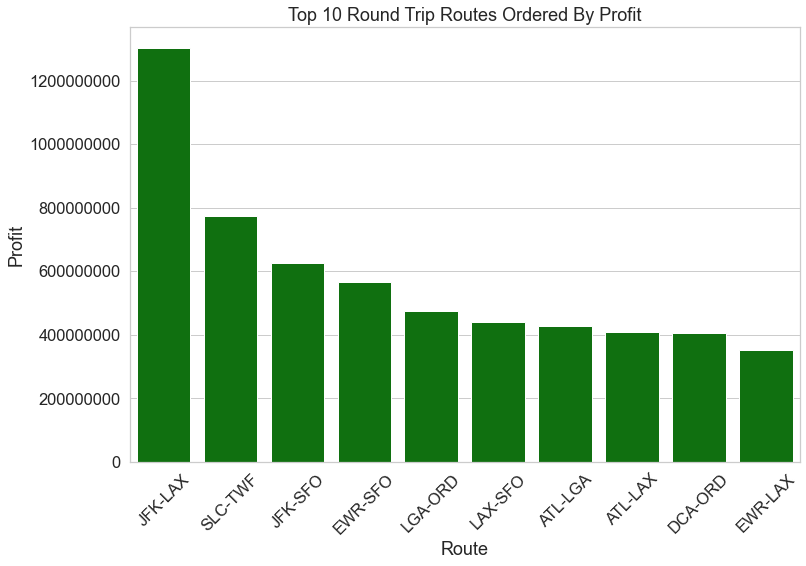

In [56]:
sns.set_style(style='whitegrid')
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
sns.barplot(data=profits.sort_values(ascending=False, by='Profit').head(10), x='Route', y='Profit', ax=ax, color='green')
plt.xlabel('Route')
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.ylabel('Profit')
plt.title('Top 10 Round Trip Routes Ordered By Profit')
plt.xticks(rotation=45)
plt.show()

#### Lets visually see the top 10 round trip routes that order by "Profit_Per_Trip" in descending Order

In [57]:
profits.sort_values(ascending=False, by='Profit_Per_Trip').head(10)

,Route,Number_Of_Competitors,Number_Of_RoundTrp_Flights,Number_Of_Passengers,Avg_Round_Trip_Fare,Tkt_Revenue,Baggage_Revenue,Total_Revenue,Avg_Departure_Delay,Avg_Arrival_Delay,Total_Delay_Cost,Fuel_Oil_Main_Crew_Costs,Depri_Insu_Oth_Costs,Air_Oper_Costs,Total_Costs,Profit_Per_Trip,Profit
2783,SLC-TWF,1,580,77504.00,10115.42,783985253.33,1356320.00,785341573.33,6.31,0.87,814050.00,812000.00,119770.00,8700000,10445820.00,1336027.16,774895753.33
1479,EGE-JFK,1,121,15780.00,3110.80,49088475.74,276150.00,49364625.74,28.73,35.14,512775.00,1690128.00,249293.88,1815000,4267196.88,372706.02,45097428.86
1297,DFW-KOA,1,89,11860.00,2684.07,31833087.14,207550.00,32040637.14,11.16,-2.82,123225.00,2651488.00,391094.48,1335000,4500807.48,309436.29,27539829.66
1576,EYW-ORD,2,143,18708.00,2230.80,41733852.59,327390.00,42061242.59,5.05,2.59,162525.00,1431144.00,211093.74,2145000,3949762.74,266513.85,38111479.85
1738,HNL-IAD,1,74,10224.00,2307.49,23591738.00,178920.00,23770658.00,2.45,-4.18,33600.00,2851664.00,420620.44,1480000,4785884.44,256550.99,18984773.56
828,CLT-FLO,1,504,65374.00,1999.00,130682626.00,1144045.00,131826671.00,4.43,1.32,448350.00,399168.00,58877.28,7560000,8466395.28,244762.45,123360275.72
1519,EWR-HNL,1,178,22866.00,2345.57,53633718.70,400155.00,54033873.70,12.55,0.92,346350.00,7065888.00,1042218.48,3560000,12014456.48,236064.14,42019417.22
2473,OGG-ORD,1,124,15534.00,2315.94,35975888.92,271845.00,36247733.92,24.18,11.08,386250.00,4150528.00,612202.88,1860000,7008980.88,235796.40,29238753.04
1562,EWR-SFO,2,2411,313516.00,2147.45,673259467.48,5486530.00,678745997.48,21.44,14.54,6886125.00,49473720.00,7297373.70,48220000,111877218.70,235117.70,566868778.78
167,ATL-HNL,1,180,23380.00,2252.08,52653553.40,409150.00,53062703.40,7.23,-12.18,153900.00,6482880.00,956224.80,3600000,11193004.80,232609.44,41869698.60


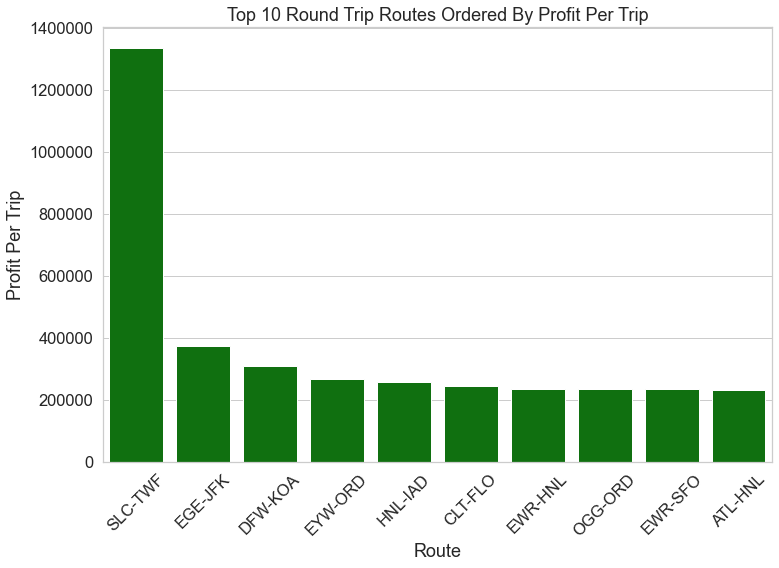

In [58]:
sns.set_style(style='whitegrid')
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
sns.barplot(data=profits.sort_values(ascending=False, by='Profit_Per_Trip').head(10), x='Route', y='Profit_Per_Trip', ax=ax, color='green')
plt.xlabel('Route')
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.ylabel('Profit Per Trip')
plt.title('Top 10 Round Trip Routes Ordered By Profit Per Trip')
plt.xticks(rotation=45)
plt.show()

##### Here from the above plot we can see that there has been a change in the routes when plotted by profit and profit per trip. We can see that there is some potential to increase profits in the routes for a the above plot but due to the less number of flights and passengers we can see that  they have lees profits.

### Question 3) The 5 round trip routes that you recommend to invest in based on any factors that you choose.


### To start in the business I would suggest to start in routes with less competetion and with more delay times, so that our client can succeed the competetion by reducing the thier flight delay times.

### 1) EWR-SFO : Since the number of competitors are 2 and the average delay times are more  and even the profit generated is good I choose this as the first one.
### 2) 	SLC-TWF	 : Since the competetion is less and the average are a bit high we can enter and succeed in this route too. This route also has the highest Profit Per Trip  so the number of flights can be increased so that the trips can increase the chance of getting more passengers and generate more profits.
### 3) LGA - ORD : Even though the number of competitors are more in the route, the average delay times in the routes are pretty high. So, our client can enter the market and can succeed there.
### 4) LXA - SFO : Even though the number of competitors are more in the route, the average delay times in the routes are a bit high. So, our client can enter the market and can succeed there. 
### 5) JFK-SFO : Even though the number of competitors are more in the route, the average delay times in the routes are a bit high. So, our client can enter the market and can succeed there.

### Question 4) The number of round trip flights it will take to breakeven on the upfront airplane cost for each of the  5 round trip routes that you recommend. Print key summary components for these routes.


<img src="https://cdn.wallstreetmojo.com/wp-content/uploads/2021/07/Break-Even-Point-Formula.jpg.webp" alt="BEP Formula" />

In [59]:
break_even_analysis=bep(profits)
break_even_analysis.sort_values(ascending=False,by='Profit_Per_Trip').head(10)

,Route,Number_Of_Competitors,Number_Of_RoundTrp_Flights,Number_Of_Passengers,Avg_Round_Trip_Fare,Tkt_Revenue,Baggage_Revenue,Total_Revenue,Avg_Departure_Delay,Avg_Arrival_Delay,Total_Delay_Cost,Fuel_Oil_Main_Crew_Costs,Depri_Insu_Oth_Costs,Air_Oper_Costs,Total_Costs,Profit_Per_Trip,Profit,Sale_Per_Trip,Cost_Per_Trip,BEP(Required_RoundTrps)
2783,SLC-TWF,1,580,77504.00,10115.42,783985253.33,1356320.00,785341573.33,6.31,0.87,814050.00,812000.00,119770.00,8700000,10445820.00,1336027.16,774895753.33,1354037.20,18010.03,68
1562,EWR-SFO,2,2411,313516.00,2147.45,673259467.48,5486530.00,678745997.48,21.44,14.54,6886125.00,49473720.00,7297373.70,48220000,111877218.70,235117.70,566868778.78,281520.53,46402.83,383
1987,JFK-LAX,4,6299,818920.00,1913.14,1566705600.03,14331100.00,1581036700.03,8.50,-1.88,8133600.00,124720200.00,18396229.50,125980000,277230029.50,206986.29,1303806670.53,250998.05,44011.75,435
2013,JFK-SFO,4,3700,480996.00,1633.03,785482367.85,8417430.00,793899797.85,15.15,6.89,8031825.00,76545600.00,11290476.00,74000000,169867901.00,168657.27,624031896.85,214567.51,45910.24,534
1526,EWR-LAX,2,2106,275124.00,1596.82,439323239.68,4814670.00,444137909.68,9.99,1.22,3186975.00,41344992.00,6098386.32,42120000,92750353.32,166850.69,351387556.36,210891.70,44041.00,540
181,ATL-LAX,6,3085,399890.47,1306.75,522557118.43,6998083.14,529555201.57,12.39,3.85,3489825.00,48051960.00,7087664.10,61700000,120329449.10,132650.16,409225752.47,171654.85,39004.68,679
1113,DCA-ORD,6,3688,477842.00,1041.35,497598596.01,8362235.00,505960831.01,10.26,6.46,6363075.00,18056448.00,2663326.08,73760000,100842849.08,109847.61,405117981.93,137191.11,27343.51,820
184,ATL-LGA,5,4589,597722.00,917.50,548409815.17,10460135.00,558869950.17,11.29,5.46,6814500.00,27974544.00,4126245.24,91780000,130695289.24,93304.57,428174660.93,121784.69,28480.12,965
2178,LGA-ORD,6,7146,927690.00,722.37,670139040.89,16234575.00,686373615.89,21.32,19.64,21919500.00,41904144.00,6180861.24,142920000,212924505.24,66253.72,473449110.65,96050.04,29796.32,1359
2137,LAX-SFO,7,8333,1081644.00,588.83,636907803.04,18928770.00,655836573.04,18.45,15.71,22041975.00,22465768.00,3313700.78,166660000,214481443.78,52964.73,441355129.26,78703.54,25738.80,1700


#### Lets see the Break Even required for all the routes I have recommended above, along with the Key metrics

In [60]:
x=break_even_analysis.loc[[1562, 2783, 2178, 2137, 2013], :]
x

,Route,Number_Of_Competitors,Number_Of_RoundTrp_Flights,Number_Of_Passengers,Avg_Round_Trip_Fare,Tkt_Revenue,Baggage_Revenue,Total_Revenue,Avg_Departure_Delay,Avg_Arrival_Delay,Total_Delay_Cost,Fuel_Oil_Main_Crew_Costs,Depri_Insu_Oth_Costs,Air_Oper_Costs,Total_Costs,Profit_Per_Trip,Profit,Sale_Per_Trip,Cost_Per_Trip,BEP(Required_RoundTrps)
1562,EWR-SFO,2,2411,313516.00,2147.45,673259467.48,5486530.00,678745997.48,21.44,14.54,6886125.00,49473720.00,7297373.70,48220000,111877218.70,235117.70,566868778.78,281520.53,46402.83,383
2783,SLC-TWF,1,580,77504.00,10115.42,783985253.33,1356320.00,785341573.33,6.31,0.87,814050.00,812000.00,119770.00,8700000,10445820.00,1336027.16,774895753.33,1354037.20,18010.03,68
2178,LGA-ORD,6,7146,927690.00,722.37,670139040.89,16234575.00,686373615.89,21.32,19.64,21919500.00,41904144.00,6180861.24,142920000,212924505.24,66253.72,473449110.65,96050.04,29796.32,1359
2137,LAX-SFO,7,8333,1081644.00,588.83,636907803.04,18928770.00,655836573.04,18.45,15.71,22041975.00,22465768.00,3313700.78,166660000,214481443.78,52964.73,441355129.26,78703.54,25738.80,1700
2013,JFK-SFO,4,3700,480996.00,1633.03,785482367.85,8417430.00,793899797.85,15.15,6.89,8031825.00,76545600.00,11290476.00,74000000,169867901.00,168657.27,624031896.85,214567.51,45910.24,534


### Question 5) Key Performance Indicators (KPI’s) that you recommend tracking in the future to measure the success of the round trip routes that you recommend.

### The KPI's I would suggest are: 
### 1) As the company believes maintaining punctuality gives them an advantage, keeping track of the delays by looking at the delay costs and average delay times for departure and arrival helps them be ahead in the competetion.
### 2) Track the number of customers going in any route using occupancy rate and ticket revenue generated over time and see if there is a positive change or possibility to enter into a new route where the competitors flight delays can be covered.
### 3) To also see the changes in number of passengers in a route and allocate the required number of flights in that route, this helps the client reduce thier costs for that route.

### Recommendations:
### 1) Use cluster analysis to identify users who frquently travel and target them by giving discounts, benefits etc. In this way people market about the company, where the company can gain good attention and attract more customers.
### 2) As we can see that the delay costs effect the profits, if in case an airline is due to a technical maintanance issue, using predictive maintenance solutions helps the maintanance team to better manage the aircraft health through the monitoring sensors. With applied predictive maintenance, an airline can reduce expenses connected with expedited transportation of parts, overtime compensation for crews, and unplanned maintenance. This helps the client manage their costs accross multiple segments.
### 3) When a disruption such as a flight delay or baggage loss occurs, travelers get nervous. And if customers don’t get a response or explanation of a problem from an airline representative in a timely manner, they likely won’t choose this airline for their next trip. The speed of response to customer queries matters as much as actual steps that are taken to solve an issue. Using AI messaging system (or) a chatbot can help the customers and give them the satisfication in a timely manner. In this way the company can also show that it values its customers, is on-brand and consistent with the business’s values.